# Self-RAG
---

### What is Self-RAG?

Self-RAG reflects on the retrieved documents and generated responses, and includes a self-evaluation process to improve the quality of the generated answers.

Original paper says Self-RAG generates special tokens, termed "reflection tokens," to determine if retrieval would enhance the response, allowing for on-demand retrieval integration. 
But in practice, we can ignore reflection tokens and let LLM decides if each document is relevant or not.

Corrective RAG (CRAG) is similar to Self-RAG, but Self-RAG focuses on self-reflection and self-evaluation, while CRAG focuses on refining the entire retrieval process including web search.

- Self-RAG: Trains the LLM to be self-sufficient in managing retrieval and generation processes. By generating reflection tokens, the model controls its behavior during inference, deciding when to retrieve information and how to critique and improve its own responses, leading to more accurate and contextually appropriate outputs. 
- CRAG: Focuses on refining the retrieval process by evaluating and correcting the retrieved documents before they are used in generation. It integrates additional retrievals, such as web searches, when initial retrievals are insufficient, ensuring that the generation is based on the most relevant and accurate information available.

**Reference**

- [Self-RAG paper](https://arxiv.org/abs/2310.11511)  

In [1]:
import asyncio
import json
import logging
import os
from collections.abc import Awaitable, Callable
from enum import Enum
from typing import Annotated, Any, ClassVar

from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential
from azure.search.documents import SearchClient
from azure.search.documents.models import VectorizableTextQuery

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from semantic_kernel import Kernel
from semantic_kernel.agents import (
    AssistantAgentThread,
    AzureAIAgent,
    AzureAIAgentSettings,
    AzureAIAgentThread,
    AzureResponsesAgent,
    ChatCompletionAgent,
    ChatHistoryAgentThread,
    ResponsesAgentThread,
)
from semantic_kernel.agents.group_chat.agent_group_chat import AgentGroupChat
from semantic_kernel.agents.strategies.termination.termination_strategy import TerminationStrategy
from semantic_kernel.connectors.ai import FunctionChoiceBehavior
from semantic_kernel.connectors.ai.open_ai import (
    AzureChatCompletion,
    AzureTextEmbedding,
    OpenAIEmbeddingPromptExecutionSettings,
)
from semantic_kernel.connectors.memory.azure_ai_search import (
    AzureAISearchCollection,
    AzureAISearchStore,
)
from semantic_kernel.connectors.search.bing import BingSearch
from semantic_kernel.contents import ChatHistory
from semantic_kernel.contents.utils.author_role import AuthorRole
from semantic_kernel.data import (
    VectorSearchOptions,
    VectorStoreRecordDataField,
    VectorStoreRecordKeyField,
    VectorStoreRecordVectorField,
    vectorstoremodel,
)
from semantic_kernel.filters import FilterTypes, FunctionInvocationContext
from semantic_kernel.functions import (
    KernelArguments,
    KernelParameterMetadata,
    KernelPlugin,
    kernel_function,
)
from semantic_kernel.kernel_pydantic import KernelBaseSettings, KernelBaseModel
from semantic_kernel.prompt_template import InputVariable, PromptTemplateConfig
from semantic_kernel.processes.kernel_process.kernel_process_step import KernelProcessStep
from semantic_kernel.processes.kernel_process.kernel_process_step_context import KernelProcessStepContext
from semantic_kernel.processes.kernel_process.kernel_process_step_state import KernelProcessStepState
from semantic_kernel.processes.local_runtime.local_event import KernelProcessEvent
from semantic_kernel.processes.local_runtime.local_kernel_process import start
from semantic_kernel.processes.process_builder import ProcessBuilder
from semantic_kernel.processes.process_function_target_builder import ProcessFunctionTargetBuilder

from azure.ai.evaluation import (
    GroundednessEvaluator,
    RelevanceEvaluator,
    RetrievalEvaluator,
)

logging.basicConfig(level=logging.WARNING)

kernel = Kernel()

load_dotenv(override=True)

True

In [2]:
# Get the environment variables
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_AI_SEARCH_API_KEY", "")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = (
    os.getenv("AZURE_OPENAI_API_KEY", "")
    if len(os.getenv("AZURE_OPENAI_API_KEY", "")) > 0
    else None
)
azure_openai_chat_deployment_name = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_embedding_deployment_name = os.getenv(
    "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002"
)
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-06-01")

model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_chat_deployment_name,
    "api_version": azure_openai_api_version,
    "type": "azure_openai",
}

embedding_model_config = {
    "azure_endpoint": azure_openai_endpoint,
    "api_key": azure_openai_key,
    "azure_deployment": azure_openai_embedding_deployment_name,
    "api_version": azure_openai_api_version,
    "type": "azure_openai",
}

## 🧪 Step 1. Test and Construct each module
---

Before building the entire the graph pipeline, we will test and construct each module separately.

- **Retrieval Grader**
- **Answer Generator**
- **Groundedness Evaluator**
- **Relevance Evaluator**
- **Question Re-writer**

### Construct Retrieval Chain based on PDF
- We use the hotels-sample-index, which can be created in minutes and runs on any search service tier. This index is created by a wizard using built-in sample data.

In [3]:
azure_ai_search_endpoint = os.getenv("AZURE_AI_SEARCH_ENDPOINT")
azure_search_admin_key = os.getenv("AZURE_AI_SEARCH_API_KEY", "")
search_client = SearchClient(
    endpoint=azure_ai_search_endpoint,
    index_name=index_name,
    credential=AzureKeyCredential(azure_search_admin_key),
    semantic_configuration_name="my-semantic-config",
)

# Query is the question being asked. It's sent to the search engine and the LLM.
query = "Can you recommend a few hotels with complimentary breakfast?"

fields = "descriptionVector"  # TODO: Check if this is the correct field name
# don't use exhaustive search for large indexes
vector_query = VectorizableTextQuery(
    text=query, k_nearest_neighbors=2, fields=fields, exhaustive=True
)

# Search results are created by the search client.
# Search results are composed of the top 3 results and the fields selected from the search index.
# Search results include the top 3 matches to your query.
search_results = search_client.search(
    search_text=query,
    vector_queries=[vector_query],
    select="Description,HotelName,Tags",
    top=3,
)
sources_formatted = "\n".join(
    [
        f'{document["HotelName"]}:{document["Description"]}:{document["Tags"]}'
        for document in search_results
    ]
)

print(sources_formatted)

Friendly Motor Inn:Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi.:['24-hour front desk service', 'continental breakfast', 'free wifi']
Lion's Den Inn:Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay.:['laundry service', 'free wifi', 'restaurant']
Starlight Suites:Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV:['pool', 'coffee in lobby', 'free wifi']


### Semantic Kernel Vector Store

This hands-on only uses Vector Store as a memory connector and a simple function that uses the add_vector_to_records function to add vectors

In [4]:
###
# The data model used for this sample is based on the hotel data model from the Azure AI Search samples.
# When deploying a new index in Azure AI Search using the import wizard you can choose to deploy the 'hotel-samples'
# dataset, see here: https://learn.microsoft.com/en-us/azure/search/search-get-started-portal.
# This is the dataset used in this sample with some modifications.
# This model adds vectors for the 2 descriptions in English and French.
# Both are based on the 1536 dimensions of the OpenAI models.
# You can adjust this at creation time and then make the change below as well.
# This sample assumes the index is deployed, the vector fields can be empty.
# If the vector fields are empty, change the first_run parameter to True to add the vectors.
###

@vectorstoremodel
class HotelSampleClass(BaseModel):
    HotelId: Annotated[str, VectorStoreRecordKeyField]
    HotelName: Annotated[str | None, VectorStoreRecordDataField()] = None
    Description: Annotated[
        str,
        VectorStoreRecordDataField(
            has_embedding=True, embedding_property_name="DescriptionVector", is_full_text_searchable=True
        ),
    ]
    DescriptionVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Description_kr: Annotated[
        str, VectorStoreRecordDataField(has_embedding=True, embedding_property_name="descriptionKOVector")
    ]
    descriptionKOVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Category: Annotated[str, VectorStoreRecordDataField()]
    Tags: Annotated[list[str], VectorStoreRecordDataField()]
    ParkingIncluded: Annotated[bool | None, VectorStoreRecordDataField()] = None
    LastRenovationDate: Annotated[str | None, VectorStoreRecordDataField()] = None
    Rating: Annotated[float, VectorStoreRecordDataField()]
    Location: Annotated[dict[str, Any], VectorStoreRecordDataField()]
    Address: Annotated[dict[str, str | None], VectorStoreRecordDataField()]
    Rooms: Annotated[list[dict[str, Any]], VectorStoreRecordDataField()]
    


In [5]:
query = "Can you recommend a few hotels with complimentary breakfast?"

COLLECTION_NAME = os.getenv("AZURE_SEARCH_INDEX_NAME", "hotels-sample-index")
kernel = Kernel()
# Add the OpenAI text embedding service

embeddings = AzureTextEmbedding(
    service_id="embedding", 
    deployment_name=azure_openai_embedding_deployment_name,
    endpoint=azure_openai_endpoint,
    api_key=azure_openai_key,
    )
kernel.add_service(embeddings)
# Create the Azure AI Search collection
collection = AzureAISearchCollection[str, HotelSampleClass](
    collection_name=COLLECTION_NAME, data_model_type=HotelSampleClass
)

# Search using just text, by default this will search all the searchable text fields in the index.
results = await collection.text_search(search_text=query)
print("Search results using text: ")
async for result in results.results:
    print(
        f"    {result.record.HotelId} (in {result.record.Address['City']}, "
        f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})"
    )

print("\n")

# Generate the vector for the query
query_vector = (await embeddings.generate_raw_embeddings([query]))[0]

print("Search results using vector: ")
# Use vectorized search to search using the vector.
results = await collection.vectorized_search(
    vector=query_vector,
    options=VectorSearchOptions(vector_field_name="descriptionVector"),
)
async for result in results.results:
    print(
        f"    {result.record.HotelId} (in {result.record.Address['City']}, "
        f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})"
    )

# Delete the collection object so that the connection is closed.
del collection

Search results using text: 


    27 (in Aventura, USA): Complimentary Airport Shuttle & WiFi. Book Now and save - Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee, HDTV (score: 4.735675)
    16 (in Seattle, USA): 5 star Luxury Hotel - Biggest Rooms in the city. #1 Hotel in the area listed by Traveler magazine. Free WiFi, Flexible check in/out, Fitness Center & espresso in room. (score: 4.458799)
    40 (in Scottsdale, USA): Only 8 miles from Downtown. On-site bar/restaurant, Free hot breakfast buffet, Free wireless internet, All non-smoking hotel. Only 15 miles from airport. (score: 3.9828727)


Search results using vector: 
    44 (in Lexington, USA): Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi. (score: 0.6665876)
    22 (in Redmond, USA): Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting spac

### Define your LLM

This hands-on only uses the `gpt-4o-mini`, but you can utilize multiple models in the pipeline.

In [6]:
service_id = "self-rag"
kernel.add_service(
    AzureChatCompletion(
        service_id=service_id,
        # api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        # endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        # deployment_name=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
        # api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
        # credential=DefaultAzureCredential()
    )
)

### Question-Retrieval Grader

Construct a retrieval grader that evaluates the relevance of the retrieved documents to the input question. The retrieval grader should take the input question and the retrieved documents as input and output a relevance score for each document.<br>
Note that the retrieval grader should be able to handle **multiple documents** as input.

In [7]:
retrieval_eval = RetrievalEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted)

retrieval_score = retrieval_eval(**query_response)
print(retrieval_score)
retrieval_score["retrieval"]

{'retrieval': 2.0, 'gpt_retrieval': 2.0, 'retrieval_reason': "The context includes one hotel that clearly offers complimentary breakfast, but the other two do not fully meet the query's requirement. The ranking is not optimal since the most relevant chunk is at the top, but the presence of a less relevant chunk could confuse the user. Thus, the overall relevance is partially met."}


2.0

### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [8]:
from pydantic import BaseModel
from typing import List


class HotelInfo(BaseModel):
    hotel_name: str
    description: str


class RecommendationList(BaseModel):
    recommendation: List[HotelInfo]

In [10]:
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion

if kernel.services.get("self-rag") is None:
    print("Adding AzureChatCompletion service")
    chat_completion = AzureChatCompletion(
        service_id="self-rag", 
        deployment_name=azure_openai_chat_deployment_name,
        endpoint=azure_openai_endpoint,
        api_key=azure_openai_key
    )
    kernel.add_service(chat_completion)

req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000
req_settings.temperature = 0.7
req_settings.response_format = RecommendationList

# This prompt provides instructions to the model
GROUNDED_PROMPT = """
You are a friendly assistant that recommends hotels based on activities and amenities.
Answer the query using only the context provided below in a friendly and concise bulleted manner.
Answer ONLY with the facts listed in the list of context below.
If there isn't enough information below, say you don't know.
Generate a response that includes the top 3 results.
Do not generate answers that don't use the context below.
Query: {{$query}}
Context:\n{{$context}}
"""


prompt_template_config = PromptTemplateConfig(
    template=GROUNDED_PROMPT,
    name="recommendation",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True),
        InputVariable(name="context", description="Context to recommend hotels", is_required=True),
    ],
    execution_settings=req_settings,
)

recommendation = kernel.add_function(
    function_name="recommendationFunc",
    plugin_name="recommendationPlugin",
    prompt_template_config=prompt_template_config,
)

response = await kernel.invoke(recommendation, query=query, context=sources_formatted)

# Load the response content as a JSON object
response_json = json.loads(response.value[0].items[0].text)

# Print the recommendations
for hotel in response_json["recommendation"]:
    print(f"Hotel Name: {hotel['hotel_name']}")
    print(f"Description: {hotel['description']}")
    print()

Hotel Name: Friendly Motor Inn
Description: Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi.

Hotel Name: Lion's Den Inn
Description: Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space.

Hotel Name: Starlight Suites
Description: Complimentary Airport Shuttle & WiFi. Spacious All Suite Hotel, Indoor Outdoor Pool, Fitness Center, Florida Green certified, Complimentary Coffee.



### Groundedness Evaluator

Construct a `groundedness_grader` node to evaluate the **hallucination** of the generated answer based on the retrieved documents.<br>

`yes` means the answer is relevant to the retrieved documents, and `no` means the answer is not relevant to the retrieved documents.

In [11]:
groundedness_eval = GroundednessEvaluator(model_config)

query_response = dict(query=query, context=sources_formatted, response=response_json)

groundedness_score = groundedness_eval(**query_response)
print(groundedness_score)

{'groundedness': 4.0, 'gpt_groundedness': 4.0, 'groundedness_reason': "The RESPONSE includes two hotels that offer breakfast, but it also includes a third hotel that does not meet the criteria. This makes the response partially correct but incomplete, as it does not fully adhere to the QUERY's request for hotels with complimentary breakfast."}


### Relevance Evaluator

Construct a `relevance_grader` node to evaluate the relevance of the generated answer to the question.<br>
`yes` means the answer is relevant to the question, and `no` means the answer is not relevant to the question.

In [12]:
relevance_eval = RelevanceEvaluator(model_config)

query_response = dict(query=query, response=response_json)

relevance_score = relevance_eval(**query_response)
print(relevance_score)

{'relevance': 4.0, 'gpt_relevance': 4.0, 'relevance_reason': 'The RESPONSE fully addresses the QUERY by providing relevant hotel recommendations that include complimentary breakfast, along with additional details about each hotel. This makes the RESPONSE complete and directly relevant to the QUERY.'}


### Question Re-writer

Construct a `question_rewriter` node to rewrite the question based on the retrieved documents and the generated answer.

In [13]:
req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id=service_id)
req_settings.max_tokens = 2000

query = "Can you recommend a few factories with complimentary breakfast?"

# This prompt provides instructions to the model
REWRITE_PROMPT = """
You a question re-writer that converts an input question to a better version that is optimized
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning based on hotel domain.
Query: {{$query}}
"""

# Send the search results and the query to the LLM to generate a response based on the prompt.
prompt_template_config = PromptTemplateConfig(
    template=REWRITE_PROMPT,
    name="rewrite",
    template_format="semantic-kernel",
    input_variables=[
        InputVariable(name="query", description="The user input", is_required=True)
    ],
    execution_settings=req_settings,
)

rewrite = kernel.add_function(
    function_name="rewriteFunc",
    plugin_name="rewritePlugin",
    prompt_template_config=prompt_template_config,
)


response = await kernel.invoke(rewrite, query=query)
# Here is the response from the chat model.
print(response)

Could you suggest some hotels that offer complimentary breakfast?


<br>

## 🧪 Step 2. Define the Agentic Architecture
- Before building the agentic pipeline, we need to design the message, topic, agent and message routing logic. 
- You should define the terminate condition for the pipeline.

### Message, Topic, Agent Definition

```markdown
```python

# Message Definition
@dataclass
class Message:
    query: str = None
    context: str = None
    response: str = None
    source: str = None


# Topic Definition
user_query_topic_type = "UserQueryTopic"
rewrite_topic_type = "RewriteQueryTopic"
generate_topic_type = "GenerateTopic"
eval_topic_type = "EvalTopic"

# Agent Definition
class RetrievalGraderAgent(RoutedAgent):
class RewriteQueryAgent(RoutedAgent):
class GenerateAgent(RoutedAgent):
class EvalAgent(RoutedAgent):
class UserAgent(RoutedAgent):

```
```

Visualizing the abstract architecture of the pipeline will help you understand the message flow and the agent's role in the pipeline.

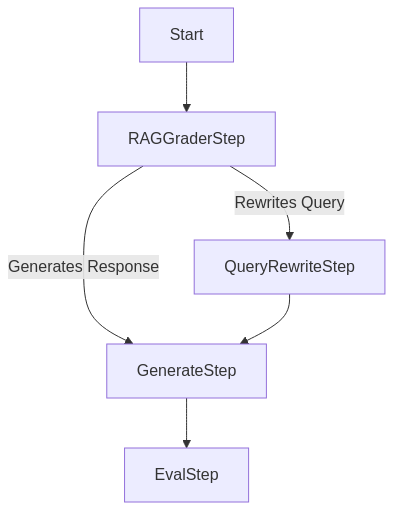

In [14]:
from azure_genai_utils.graphs import visualize_agents

agents = [
    "Start",
    "RAGGraderStep",
    "QueryRewriteStep",
    "GenerateStep",
    "EvalStep"
]
interactions = [
    ("Start", "RAGGraderStep"),
    ("RAGGraderStep", "GenerateStep", "Generates Response"),
    ("RAGGraderStep", "QueryRewriteStep", "Rewrites Query"),
    ("QueryRewriteStep", "GenerateStep"),
    ("GenerateStep", "EvalStep")
]

visualize_agents(agents, interactions)

This is an example of visualized pipeline

!["self-RAG"](../../images/SK_self_rag.png)

In [15]:
# Define the events for the process
class CommonEvents(Enum):
    StartProcess = "StartProcess"
    UserInputReceived = "UserInputReceived"
    Exit = "exit"

class ReflectionEvents(Enum):
    
    LowRAGGrade = "LowRAGGrade"
    RAGGraderDone = "RAGGraderDone"
    QueryRewriteDone = "QueryRewriteDone"
    ResponseGenerated = "ResponseGenerated"
    EvalDone = "EvalDone"
    
    RAGGraderRequested = "RAGGraderRequested"
    QueryRewriteRequested = "QueryRewriteRequested"
    ResponseGenerateRequested = "ResponseGenerateRequested"
    EvalRequested = "EvalRequested"
    
@vectorstoremodel
class HotelSampleClass(BaseModel):
    HotelId: Annotated[str, VectorStoreRecordKeyField]
    HotelName: Annotated[str | None, VectorStoreRecordDataField()] = None
    Description: Annotated[
        str,
        VectorStoreRecordDataField(
            has_embedding=True, embedding_property_name="DescriptionVector", is_full_text_searchable=True
        ),
    ]
    DescriptionVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Description_kr: Annotated[
        str, VectorStoreRecordDataField(has_embedding=True, embedding_property_name="descriptionKOVector")
    ]
    descriptionKOVector: Annotated[
        list[float] | None,
        VectorStoreRecordVectorField(
            dimensions=1536,
            local_embedding=True,
            embedding_settings={"embedding": OpenAIEmbeddingPromptExecutionSettings(dimensions=1536)},
        ),
    ] = None
    Category: Annotated[str, VectorStoreRecordDataField()]
    Tags: Annotated[list[str], VectorStoreRecordDataField()]
    ParkingIncluded: Annotated[bool | None, VectorStoreRecordDataField()] = None
    LastRenovationDate: Annotated[str | None, VectorStoreRecordDataField()] = None
    Rating: Annotated[float, VectorStoreRecordDataField()]
    Location: Annotated[dict[str, Any], VectorStoreRecordDataField()]
    Address: Annotated[dict[str, str | None], VectorStoreRecordDataField()]
    Rooms: Annotated[list[dict[str, Any]], VectorStoreRecordDataField()]
    
    
class UserInputState(KernelBaseModel):
    user_inputs: list[str] = []
    current_input_index: int = 0

class UserInputStep(KernelProcessStep[UserInputState]):
    GET_USER_INPUT: ClassVar[str] = "get_user_input"

    def create_default_state(self) -> "UserInputState":
        """Creates the default UserInputState."""
        return UserInputState()

    def populate_user_inputs(self):
        """Method to be overridden by the user to populate with custom user messages."""
        pass

    async def activate(self, state: KernelProcessStepState[UserInputState]):
        """Activates the step and sets the state."""
        state.state = state.state or self.create_default_state()
        self.state = state.state
        self.populate_user_inputs()

    @kernel_function(name=GET_USER_INPUT)
    async def get_user_input(self, context: KernelProcessStepContext):
        """Gets the user input."""
        if not self.state:
            raise ValueError("State has not been initialized")

        #user_message = input("USER: ")
        #user_message = "Can you recommend a few hotels with complimentary breakfast?"
        user_message = "Can you recommend a few hoels with complimentary breakfast?"

        if "exit" in user_message:
            await context.emit_event(process_event=CommonEvents.Exit, data=None)
            return

        self.state.current_input_index += 1
        
        data = {
            "query": user_message
        }
        
        print(f"{'-'*80}\n{self.GET_USER_INPUT}:\n{user_message}")
        await context.emit_event(process_event=ReflectionEvents.RAGGraderRequested, data=data)

class RAGGraderStep(KernelProcessStep):
    RAG_GRADER: ClassVar[str] = "RAGGraderStep"
    
    retrieval_eval: RetrievalEvaluator | None = None
        
    @kernel_function(name=RAG_GRADER)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        query = data["query"]
        retrieval_context = data.get("context", "")


        COLLECTION_NAME = "hotels-sample-index"
        
        
        # Create the Azure AI Search collection
        collection = AzureAISearchCollection[str, HotelSampleClass](
            collection_name=COLLECTION_NAME, data_model_type=HotelSampleClass,
        )
        
        embeddings = kernel.get_service("embedding")
                
        query_vector = (await embeddings.generate_raw_embeddings(query))[0]
        
        
        if retrieval_context == "":
            results = await collection.vectorized_search(
            vector=query_vector,
            options=VectorSearchOptions(vector_field_name="descriptionVector"),
            )

            async for result in results.results:
                retrieval_context += (
                    f"    {result.record.HotelId} (in {result.record.Address['City']}, "
                    f"{result.record.Address['Country']}): {result.record.Description} (score: {result.score})\n"
                )

        
        data = {
            "query": query,
            "context": retrieval_context,
        }
        
        print(f"{'-'*80}\n{self.RAG_GRADER}:\n{retrieval_context}")
        retrieval_score = self.retrieval_eval(**data)
        print(retrieval_score)
        
        if retrieval_score["retrieval"] >= 3.0:
            await context.emit_event(process_event=ReflectionEvents.RAGGraderDone, data=data)
        else:
            await context.emit_event(process_event=ReflectionEvents.LowRAGGrade, data=data)
        


class QueryRewriteStep(KernelProcessStep):
    QUERY_REWRITE: ClassVar[str] = "QueryRewriteStep"
    
    @kernel_function(name=QUERY_REWRITE)
    async def do_it(self, context: KernelProcessStepContext, data:dict, kernel: Kernel):
        
        query = data["query"]
        retrieval_context = data["context"]
        
        req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id="default")
        

        
        # This prompt provides instructions to the model
        REWRITE_PROMPT = """
        You a question re-writer that converts an input question to a better version that is optimized
        for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning based on hotel domain.
        Query: {{$query}}
        """

        # Send the search results and the query to the LLM to generate a response based on the prompt.
        prompt_template_config = PromptTemplateConfig(
            template=REWRITE_PROMPT,
            name="rewrite",
            template_format="semantic-kernel",
            input_variables=[
                InputVariable(name="query", description="The user input", is_required=True)
            ],
            execution_settings=req_settings,
        )

        rewrite = kernel.add_function(
            function_name="rewriteFunc",
            plugin_name="rewritePlugin",
            prompt_template_config=prompt_template_config,
        )


        response = await kernel.invoke(rewrite, query=query, 
                                       function_name="rewriteFunc")
        
        data = {
            "query": response,
            "context": retrieval_context,
        }
        
        print(f"{'-'*80}\n{self.QUERY_REWRITE}:\n{response}")
        await context.emit_event(process_event=ReflectionEvents.QueryRewriteDone, data=data)
  

class GenerateStep(KernelProcessStep):
    GENERATE: ClassVar[str] = "GenerateStep"
    
    @kernel_function(name=GENERATE)
    async def do_it(self, context: KernelProcessStepContext, data:dict, kernel: Kernel):
        
        query = data["query"]
        retrieval_context = data["context"]
        
        req_settings = kernel.get_prompt_execution_settings_from_service_id(service_id="default")
        
        # This prompt provides instructions to the model
        GROUNDED_PROMPT = """
        Answer the query using only the context provided below in a friendly and concise bulleted manner.
        Answer ONLY with the facts listed in the list of context below.
        If there isn't enough information below, say you don't know.
        Do not generate answers that don't use the context below.
        Query: {{$query}}
        Context:\n{{$context}}
        """

        # Send the search results and the query to the LLM to generate a response based on the prompt.
        prompt_template_config = PromptTemplateConfig(
            template=GROUNDED_PROMPT,
            name="generate",
            template_format="semantic-kernel",
            input_variables=[
                InputVariable(name="query", description="The user input", is_required=True),
                InputVariable(name="context", description="context", is_required=True)
            ],
            execution_settings=req_settings,
        )

        generate = kernel.add_function(
            function_name="generateFunc",
            plugin_name="generatePlugin",
            prompt_template_config=prompt_template_config,
        )


        response = await kernel.invoke(generate, query=query, context=retrieval_context,
                                       function_name="generateFunc")
        
        
        data = {
            "query": query,
            "context": retrieval_context,
            "response": response
        }
        
        
        print(f"{'-'*80}\n{self.GENERATE}:\n{response}")
        await context.emit_event(process_event=ReflectionEvents.ResponseGenerated, data=data)
        
        
class EvalStep(KernelProcessStep):
    EVALSTEP: ClassVar[str] = "EvalStep"
    
    groundedness_eval: GroundednessEvaluator | None = None
    relevance_eval: RelevanceEvaluator | None = None
    
    @kernel_function(name=EVALSTEP)
    async def do_it(self, context: KernelProcessStepContext, data: dict, kernel: Kernel):
        
        INCORRECT_ANSWER = """
        Hello, and thank you for bringing this to our attention! I may have provided an inaccurate or misleading response, and I sincerely apologize for the confusion.
        As an AI, I aim to deliver helpful and accurate information, but sometimes I might misinterpret or generate an incorrect response. Your feedback is invaluable and helps me improve.

        If you'd like, feel free to share more details or clarify your question, and I’ll do my best to assist you further. Thank you for your understanding and patience! 😊
        """
                    
        print(f"{'-'*80}\n{self.EVALSTEP}\n")
        # print("\nData Object:")
        # for key, value in data.items():
        #     print(f"{key}: {value}")
    
        groundedness_score = self.groundedness_eval(**data)
        print(groundedness_score)
        
        relevance_score = self.relevance_eval(**data)
        print(relevance_score)
        
        if groundedness_score["groundedness"] < 3.0 or relevance_score["relevance"] < 3.0:
            print(INCORRECT_ANSWER)
        else:
            print("Groundedness and relevance scores are acceptable.")


<br>

## 🧪 Step 3. Execute the Workflow
---

### Execute the workflow

In [16]:
kernel = Kernel()

if kernel.services.get("embedding") is None:
    print("Adding AzureTextEmbedding service")
    embeddings = AzureTextEmbedding(
        service_id="embedding", 
        deployment_name=azure_openai_embedding_deployment_name,
        endpoint=azure_openai_endpoint,
        api_key=azure_openai_key,
    )
    kernel.add_service(embeddings)
    
if kernel.services.get("self-rag") is None:
    print("Adding AzureChatCompletion service")
    chat_completion = AzureChatCompletion(
        service_id="self-rag", 
        deployment_name=azure_openai_chat_deployment_name,
        endpoint=azure_openai_endpoint,
        api_key=azure_openai_key
    )
    kernel.add_service(chat_completion)
    

async def raggrader_step_factory():
    retrieval_eval = RetrievalEvaluator(model_config)
    step_instance = RAGGraderStep()
    step_instance.retrieval_eval = retrieval_eval
    return step_instance

async def eval_step_factory():
    groundedness_eval = GroundednessEvaluator(model_config)
    relevance_eval = RelevanceEvaluator(model_config)
    step_instance = EvalStep()
    step_instance.groundedness_eval = groundedness_eval
    step_instance.relevance_eval = relevance_eval
    return step_instance


def build_process():
    
    process = ProcessBuilder(name="Test Process")
    # Add the step types to the builder
    user_input_step = process.add_step(step_type=UserInputStep)
    RAG_grader_step = process.add_step(
        step_type=RAGGraderStep, factory_function=raggrader_step_factory
    )
    query_rewrite_step = process.add_step(step_type=QueryRewriteStep)
    generate_step = process.add_step(step_type=GenerateStep)
    
    eval_step = process.add_step(
        step_type=EvalStep, factory_function=eval_step_factory
    )
    
    # Define the input event and where to send it to
    process.on_input_event(event_id=CommonEvents.StartProcess).send_event_to(target=user_input_step)

    # Define the process flow
    user_input_step.on_event(event_id=ReflectionEvents.RAGGraderRequested).send_event_to(target=RAG_grader_step, parameter_name="data")
    
    RAG_grader_step.on_event(event_id=ReflectionEvents.RAGGraderDone).send_event_to(target=generate_step, parameter_name="data")
    RAG_grader_step.on_event(event_id=ReflectionEvents.LowRAGGrade).send_event_to(target=query_rewrite_step, parameter_name="data")
    
    query_rewrite_step.on_event(event_id=ReflectionEvents.QueryRewriteDone).send_event_to(target=generate_step, parameter_name="data")
    
    generate_step.on_event(event_id=ReflectionEvents.ResponseGenerated).send_event_to(target=eval_step, parameter_name="data")


    return process.build()


async def self_rag_process():
    
    # Build the process
    kernel_process = build_process()

    # Start the process
    await start(
        process=kernel_process,
        kernel=kernel,
        initial_event=KernelProcessEvent(id=CommonEvents.StartProcess, data=[]),
    )

import time

start_time = time.perf_counter()
await self_rag_process()
end_time = time.perf_counter()
print(f"Elapsed time: {end_time - start_time} seconds")

Adding AzureTextEmbedding service
Adding AzureChatCompletion service
--------------------------------------------------------------------------------
get_user_input:
Can you recommend a few hoels with complimentary breakfast?


--------------------------------------------------------------------------------
RAGGraderStep:
    22 (in Redmond, USA): Full breakfast buffet for 2 for only $1. Excited to show off our room upgrades, faster high speed WiFi, updated corridors & meeting space. Come relax and enjoy your stay. (score: 0.6467861)
    33 (in Detroit, USA): Book Now & Save. Clean, Comfortable rooms at the lowest price. Enjoy complimentary coffee and tea in common areas. (score: 0.6437663)
    44 (in Lexington, USA): Close to historic sites, local attractions, and urban parks. Free Shuttle to the airport and casinos. Free breakfast and WiFi. (score: 0.6437369)

{'retrieval': 2.0, 'gpt_retrieval': 2.0, 'retrieval_reason': 'The context contains relevant information about hotels with complimentary breakfast, but the most pertinent chunk is not at the top of the list. Therefore, it fits the definition of "Partially Relevant Context, Poor Ranking, External Knowledge Bias," which suggests a score of 2.'}
---------